Выполнено Олейник Софией в рамках дисциплины "Аналитика данных на Python" магистратуры ИТМО.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# считываем данные с явным указанием типа
data = pd.read_csv(
    "data/Econom_Cities_data.csv",
    sep=";",
    decimal=",",
    dtype = {
        "City": str,
        "Work": int,
        "Price": float,
        "Salary": float
    }
)
data.set_index("City", inplace=True)
data.head()

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5


In [3]:
# очистка данных от выбросов
data_cleaned = data.copy()
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data_cleaned = data_cleaned[(data_cleaned[col] >= lower) & (data_cleaned[col] <= upper)]

In [4]:
# стандартизация данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns, index=data_cleaned.index)

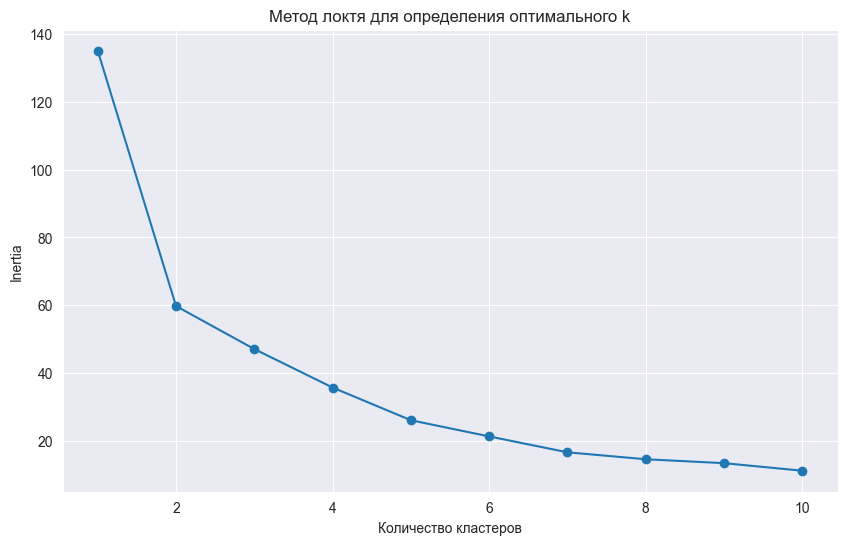

In [5]:
# метод локтя для определения оптимального количества кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)
plt.show()

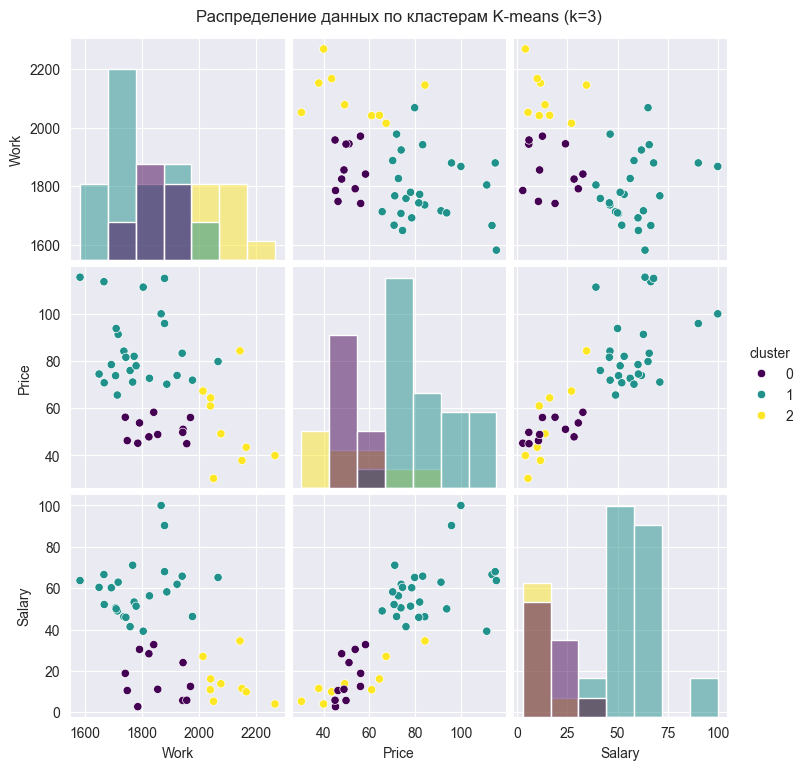

In [6]:
# кластеризация с оптимальным количеством кластеров
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_cleaned['cluster'] = kmeans.fit_predict(data_scaled)

# визуализация кластеров
sns.pairplot(data_cleaned, hue='cluster', palette='viridis', diag_kind='hist')
plt.suptitle(f'Распределение данных по кластерам K-means (k={optimal_k})', y=1.02)
plt.show()

In [7]:
# анализ центроидов кластеров
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=data_cleaned.columns[:-1]
)
centroids['cluster'] = range(optimal_k)

print("Центроиды кластеров:")
print(centroids)

print("\nСтатистика по кластерам:")
print(data_cleaned.groupby('cluster').describe())

Центроиды кластеров:
          Work      Price     Salary  cluster
0  1855.454545  50.781818  16.590909        0
1  1789.240000  84.972000  59.032000        1
2  2106.666667  53.100000  14.777778        2

Статистика по кластерам:
         Work                                                           \
        count         mean         std     min     25%     50%     75%   
cluster                                                                  
0        11.0  1855.454545   85.958552  1742.0  1789.0  1842.0  1944.5   
1        25.0  1789.240000  115.472681  1583.0  1710.0  1768.0  1880.0   
2         9.0  2106.666667   82.082276  2015.0  2042.0  2078.0  2152.0   

                Price             ...               Salary             \
            max count       mean  ...    75%    max  count       mean   
cluster                           ...                                   
0        1971.0  11.0  50.781818  ...  54.95   58.3   11.0  16.590909   
1        2068.0  25.0  84.972000

Text(0, 0.5, 'Количество городов')

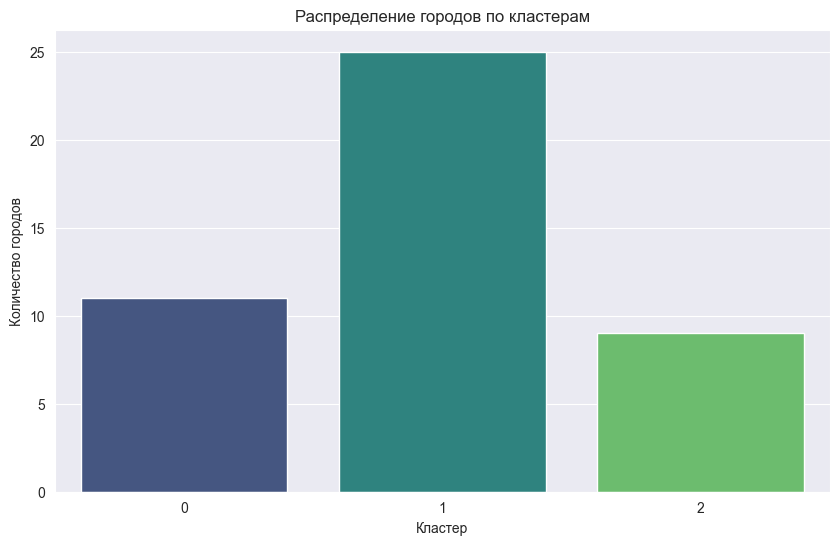

In [16]:
# распределение городов по кластерам
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='cluster', palette='viridis')
plt.title('Распределение городов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество городов')